In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [2]:
!pip install -U transformers

In [3]:
import os

In [4]:
!pip install -U transformers datasets
os.environ["WANDB_DISABLED"] = "true"

In [5]:
# Define all file names and labels
files = {
    "twitter_parsed_dataset.csv": "twitter",
    "twitter_racism_parsed_dataset.csv": "racism",
    "twitter_sexism_parsed_dataset.csv": "sexism",
    "youtube_parsed_dataset.csv": "youtube"
}

all_dfs = []

for file, label in files.items():
    df = pd.read_csv(file)
    text_col = None
    for col in df.columns:
        if 'text' in col.lower():
            text_col = col
            break
    if not text_col:
        raise ValueError(f"Couldn't find a text column in {file}")
    df = df[[text_col]].dropna().copy()
    df.columns = ['text']
    df['label'] = label
    all_dfs.append(df)

final_df = pd.concat(all_dfs).reset_index(drop=True)
final_df.head()

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,twitter
1,@ShreyaBafna3 Now you idiots claim that people...,twitter
2,"RT @Mooseoftorment Call me sexist, but when I ...",twitter
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",twitter
4,#mkr No No No No No No,twitter


In [6]:
# Sample 2000 entries per label to balance the dataset
sample_df = final_df.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)

# Encode labels into integers
le = LabelEncoder()
sample_df['label_encoded'] = le.fit_transform(sample_df['label'])

# Check results
sample_df[['label', 'label_encoded']].drop_duplicates()

/tmp/ipython-input-6-3204026891.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = final_df.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)


,label,label_encoded
0,racism,0
2000,sexism,1
4000,twitter,2
6000,youtube,3


In [7]:
# Split into train and validation sets (90/10 split)
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    sample_df['text'].tolist(),
    sample_df['label_encoded'].tolist(),
    test_size=0.1,
    stratify=sample_df['label_encoded'],
    random_state=42
)

In [8]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize train and validation sets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:

!pip install -q datasets

In [10]:
from datasets import Dataset

# Rebuild train and validation into HF-compatible Dataset format
train_dict = {
    'text': train_texts,
    'label': train_labels
}

val_dict = {
    'text': val_texts,
    'label': val_labels
}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)

In [11]:
def tokenize_fn(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

# Rename label column for Trainer compatibility
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

# Set format to PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [12]:
from transformers import DistilBertForSequenceClassification

# Number of unique labels (classes)
num_labels = len(set(train_labels))

# Load pretrained DistilBERT model with classification head
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
from transformers import DistilBertForSequenceClassification
num_labels = len(set(train_labels))  # or len(set(sample_df['label_encoded']))
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import Trainer, EvalPrediction
import numpy as np
from sklearn.metrics import accuracy_score
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()


Step,Training Loss
50,1.307200
100,0.924600
150,0.891700
200,0.863800
250,0.901700
300,0.884000
350,0.863300
400,0.858300
450,0.861300
500,0.845500


TrainOutput(global_step=900, training_loss=0.8716072675916884, metrics={'train_runtime': 177.7276, 'train_samples_per_second': 81.023, 'train_steps_per_second': 5.064, 'total_flos': 476899644211200.0, 'train_loss': 0.8716072675916884, 'epoch': 2.0})

In [16]:
# Evaluate model on validation set
trainer.evaluate()

{'eval_loss': 0.8418189883232117,
 'eval_accuracy': 0.49625,
 'eval_runtime': 2.4966,
 'eval_samples_per_second': 320.439,
 'eval_steps_per_second': 5.207,
 'epoch': 2.0}

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(final_df['label'])

LabelEncoder()

In [19]:
%reset -f

In [20]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [21]:
!pip install -U transformers

In [22]:
import os

In [23]:
!pip install -U transformers datasets
os.environ["WANDB_DISABLED"] = "true"

In [25]:
# Define all file names and labels
files = {
    "toxicity_parsed_dataset.csv": "toxicity",
    "twitter_racism_parsed_dataset.csv": "racism",
    "twitter_sexism_parsed_dataset.csv": "sexism",
    "youtube_parsed_dataset.csv": "youtube"
}

all_dfs = []

for file, label in files.items():
    df = pd.read_csv(file)
    text_col = None
    for col in df.columns:
        if 'text' in col.lower():
            text_col = col
            break
    if not text_col:
        raise ValueError(f"Couldn't find a text column in {file}")
    df = df[[text_col]].dropna().copy()
    df.columns = ['text']
    df['label'] = label
    all_dfs.append(df)

final_df = pd.concat(all_dfs).reset_index(drop=True)
final_df.head()

,text,label
0,This: :One can make an analogy in mathematical...,toxicity
1,` :Clarification for you (and Zundark's righ...,toxicity
2,Elected or Electoral? JHK,toxicity
3,`This is such a fun entry. Devotchka I once...,toxicity
4,Please relate the ozone hole to increases in c...,toxicity


In [26]:
from sklearn.utils import resample
import pandas as pd

# Get the smallest class count
min_count = 1970

# Balanced list
balanced = []

# Loop through each label and resample
for label in final_df["label"].unique():
    label_df = final_df[final_df["label"] == label]
    if len(label_df) > min_count:
        resampled = resample(label_df, replace=False, n_samples=min_count, random_state=42)
    else:
        resampled = resample(label_df, replace=True, n_samples=min_count, random_state=42)
    balanced.append(resampled)

# Concatenate all balanced samples
balanced_df = pd.concat(balanced).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print("New Label Distribution:")
print(balanced_df["label"].value_counts())

New Label Distribution:
label
toxicity    1970
racism      1970
youtube     1970
sexism      1970
Name: count, dtype: int64


In [27]:
# New label encoding
label_map = {'toxicity': 0, 'racism': 1, 'youtube': 2, 'sexism': 3}
balanced_df['label_encoded'] = balanced_df['label'].map(label_map)

In [28]:
import re

def clean(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

balanced_df["clean_text"] = balanced_df["text"].apply(clean)

In [33]:
# Split into train and validation sets (90/10 split)
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['text'].tolist(),
    balanced_df['label_encoded'].tolist(),
    test_size=0.1,
    stratify=balanced_df['label_encoded'],
    random_state=42
)

In [34]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize train and validation sets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [35]:
!pip install -q datasets

In [36]:
from datasets import Dataset

# Rebuild train and validation into HF-compatible Dataset format
train_dict = {
    'text': train_texts,
    'label': train_labels
}

val_dict = {
    'text': val_texts,
    'label': val_labels
}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)

In [37]:
def tokenize_fn(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

# Rename label column for Trainer compatibility
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

# Set format to PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/7092 [00:00<?, ? examples/s]

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

In [38]:

from transformers import DistilBertForSequenceClassification# Number of unique labels (classes)num_labels = len(set(train_labels))# Load pretrained DistilBERT model with classification headmodel = DistilBertForSequenceClassification.from_pretrained(    'distilbert-base-uncased',    num_labels=num_labels)

In [40]:

from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [41]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average='macro')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [42]:
trainer.train()

Step,Training Loss
10,1.385100
20,1.364300
30,1.327100
40,1.223100
50,0.994100
60,0.809600
70,0.646800
80,0.663200
90,0.529100
100,0.487500


TrainOutput(global_step=1776, training_loss=0.3667051704885723, metrics={'train_runtime': 303.3996, 'train_samples_per_second': 93.5, 'train_steps_per_second': 5.854, 'total_flos': 939492299096064.0, 'train_loss': 0.3667051704885723, 'epoch': 4.0})

In [45]:
# Evaluate model on validation set
trainer.evaluate()

{'eval_loss': 0.6470827460289001,
 'eval_accuracy': 0.7373096446700508,
 'eval_macro_f1': 0.7378934462747743,
 'eval_runtime': 2.8971,
 'eval_samples_per_second': 271.999,
 'eval_steps_per_second': 8.629,
 'epoch': 4.0}

In [47]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

val_encodings = tokenizer(
    val_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [48]:
import torch

val_labels_tensor = torch.tensor(val_labels)

In [50]:
from torch.utils.data import Dataset

class ValDataset(Dataset):
    def _init_(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def _len_(self):
        return len(self.labels)

    def _getitem_(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }



In [51]:
from torch.utils.data import DataLoader

val_loader = DataLoader(val_dataset, batch_size=32)

In [53]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [56]:
all_preds = []
all_labels = []

model.to(device)
model.eval()

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        label_key = 'label' if 'label' in batch else 'labels'
        labels = batch[label_key].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

<Figure size 800x600 with 0 Axes>

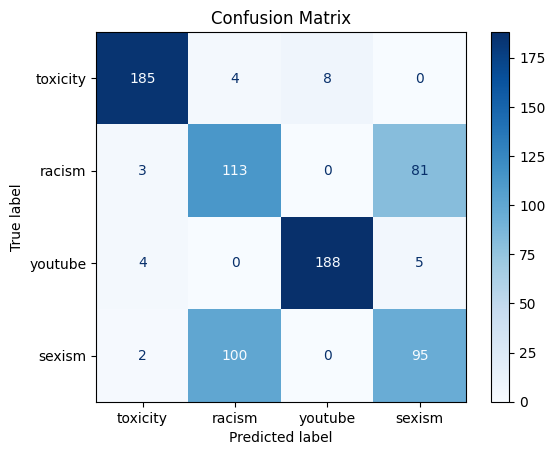

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define class names (edit if needed)
label_names = ['toxicity', 'racism', 'youtube', 'sexism']

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [58]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

Classification Report:
              precision    recall  f1-score   support

    toxicity       0.95      0.94      0.95       197
      racism       0.52      0.57      0.55       197
     youtube       0.96      0.95      0.96       197
      sexism       0.52      0.48      0.50       197

    accuracy                           0.74       788
   macro avg       0.74      0.74      0.74       788
weighted avg       0.74      0.74      0.74       788

